# Reconstruction of Chelyabinsk orbit
This notebook uses the radiant and the velocity of the Chelyabinsk meteor to reconstruct its pre-impact orbit. The initial parameters have been provided by Peter Brown (see http://adsabs.harvard.edu/abs/2013Natur.503..235B).

We first impot rebound and a couple of other modules. Most notably astropy which we use to convert between UTC and TCB as well as between Alt/Az and Ra/Dec.

In [1]:
%matplotlib inline
import rebound
import os
import numpy as np
import datetime
import corner
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import matplotlib.pyplot as plt

Next, a couple of straight forward routines to convert Ra/Dec to Cartesian coordinates. We also implement the first and second order derivatives as we need those later for the variational equations.

In [2]:
def radec2xyz(ra, dec):
    x = np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = np.sin(np.pi/180.*dec)
    return np.array([x, y, z])

def radec2xyz_dra(ra, dec):
    x = -np.pi/180.*np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    y = np.pi/180.*np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    z = 0.
    return np.array([x, y, z])

def radec2xyz_ddra(ra, dec):
    x = -np.pi/180.*np.pi/180.*np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = -np.pi/180.*np.pi/180.*np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = 0.
    return np.array([x, y, z])

def radec2xyz_ddec(ra, dec):
    x = -np.pi/180.*np.sin(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = -np.pi/180.*np.sin(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = np.pi/180.*np.cos(np.pi/180.*dec)
    return np.array([x, y, z])

def radec2xyz_dddec(ra, dec):
    x = -np.pi/180.*np.pi/180.*np.cos(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    y = -np.pi/180.*np.pi/180.*np.cos(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    z = -np.pi/180.*np.pi/180.*np.sin(np.pi/180.*dec)
    return np.array([x, y, z])

def radec2xyz_dra_ddec(ra, dec):
    x = np.pi/180.*np.pi/180.*np.sin(np.pi/180.*dec)*np.sin(np.pi/180.*ra)
    y = -np.pi/180.*np.pi/180.*np.sin(np.pi/180.*dec)*np.cos(np.pi/180.*ra)
    z = 0.
    return np.array([x, y, z])

def mod360(a):
    while a>360.:
        a-=360.
    while a<0.:
        a+=360.
    return a

We can now setup all the observed meteor properties, most importantly, the time, location, radiant and velocity. 

In [3]:
# Meteor properties:
time = "2013-02-15 03:20:21.1" # Time [UTC]
v = 19.03                      # velocity relative to Earth [km/s]
v_err = 0.013                  # ^error
ra = 328.12                    # radiant right ascension [degree]
ra_err = 0.1                   # ^error
dec = 7.41                     # radiant declination [degree]
dec_err = 0.05                 # ^error
height = 95.*6.6845871e-09     # height [AU]
lat = 54.4540                  # latitude [degree]
lon = 64.4739                  # longitude [degree]

We'll also need a few physical constants.

In [4]:
# Physical constants
re = 4.2587571e-05             # Earth radius [AU]
day = 0.017202791              # Earth day [year/(2*pi)]
inc = 23.4392911111111         # Inclination of ecliptic [degree]

vconv = 0.033572943            # 1km/s in 2*pi*AU/year
v *= vconv
v_err *= vconv

We can now setup the Solar System at the time of impact. We query NASA Horizons to get accurate emphermeris data. We work in the ICRS frame, not the ecliptic (thus the Solar System is inclined with respect to the xy axis). This makes it straightforward to convert from Ra/Dec to Cartesian. Because NASA Horizons is a little slow, we cache the data locally.

In [5]:
event = Time(time, format="iso", scale="utc")
aa_frame = AltAz(location=EarthLocation(lat=lat,lon=lon), obstime=event)

# Cache Horizon data
if not os.path.isfile("ss.bin"):
    sim = rebound.Simulation()
    te_tcb = datetime.datetime.strptime(event.tcb.iso,"%Y-%m-%d %H:%M:%S.%f")
    for p in ["Sun","Mercury","Venus","399", "301", "Mars", "Jupiter", "Saturn"]:
        sim.add(p, date=te_tcb, plane="frame")
    sim.save("ss.bin")
else:
    sim = rebound.Simulation.from_file("ss.bin")

Next, we create a particle corresponding to the meteor. We start by copying the particle representing the Earth and then adjust its mass, velocity and position.

In [6]:
# Create new meteor particle
p = sim.particles[3].copy()
p.m = 0.

# Add velocity of meteor relative to Earth's atmosphere 
p.vxyz = np.array(p.vxyz) - v*radec2xyz(ra,dec)

# Add velocity of Earth's atmosphere relative to Earth
east = SkyCoord('90deg 0deg',frame=aa_frame).transform_to("icrs")
p.vxyz = np.array(p.vxyz) + 2.*np.pi*np.cos(lat*np.pi/180.)*(re+height)/day *radec2xyz(east.ra.value, east.dec.value)

# Add position relative to Earth
up = SkyCoord('0deg 90deg',frame=aa_frame).transform_to("icrs")
p.xyz = np.array(p.xyz) + (re + height) *radec2xyz(up.ra.value, up.dec.value)

sim.add(p)

# Save the simulation for later
sim.save("ss1.bin")

We will second order variational equations to estimate the error on the pre-impact orbit. Because we have three uncertain meassurements (velocity and radiant direction) we need to setup 3 sets of first order variational equations. The uncertainties are large, thus we require second order variational equations as well. These are another three sets of equations. 

In [7]:
# Add variations
var_dv = sim.add_variation(testparticle=8)
var_dv.particles[0].vxyz = -radec2xyz(ra,dec)

var_ddv = sim.add_variation(testparticle=8, order=2, first_order=var_dv)

var_dra = sim.add_variation(testparticle=8)
var_dra.particles[0].vxyz = -v*radec2xyz_dra(ra,dec)

var_ddra = sim.add_variation(testparticle=8, order=2, first_order=var_dra)
var_ddra.particles[0].vxyz = -v*radec2xyz_ddra(ra,dec)

var_ddec = sim.add_variation(testparticle=8)
var_ddec.particles[0].vxyz = -v*radec2xyz_ddec(ra,dec)

var_dddec = sim.add_variation(testparticle=8, order=2, first_order=var_ddec)
var_dddec.particles[0].vxyz = -v*radec2xyz_dddec(ra,dec)

var_dra_ddec = sim.add_variation(testparticle=8, order=2, first_order=var_dra, first_order_2=var_ddec)
var_dra_ddec.particles[0].vxyz = -v*radec2xyz_dra_ddec(ra,dec)

var_dv_dra = sim.add_variation(testparticle=8, order=2, first_order=var_dra, first_order_2=var_dv)
var_dv_dra.particles[0].vxyz = -radec2xyz_ddra(ra,dec)

var_dv_ddec = sim.add_variation(testparticle=8, order=2, first_order=var_ddec, first_order_2=var_dv)
var_dv_ddec.particles[0].vxyz = -radec2xyz_ddec(ra,dec)

We can now finally integrate the system backwards in time for 60 days. This brings the meteor well out of the Earth's potential well. After the integration, we rotate the coordinate system to bring it into the ecliptic (Solar System orbits are typicall given with respect to the ecliptic).

In [8]:
sim.dt = 1e-6
sim.ri_ias15.min_dt = sim.dt
sim.integrate(-60.*day)

# Rotate to ecliptic frame to calculate orbital parameters
cos = np.cos(inc/180.*np.pi)
sin = np.sin(inc/180.*np.pi)
for p in sim.particles:
    p.y, p.z = cos*p.y + sin*p.z, -sin*p.y + cos*p.z
    p.vy, p.vz = cos*p.vy + sin*p.vz, -sin*p.vy + cos*p.vz

# Save simulation for later
sim.save("ss2.bin")

We can now use the first and second order variational equations to sample the pre-impact orbit. Note that this is a very fast method as we do not need to integrate the orbit.

In [9]:
N=10000
samples = np.zeros((N,5))
for i in range(N):
    dv   = v_err   * np.random.normal()
    dra  = ra_err  * np.random.normal()
    ddec = dec_err * np.random.normal()
    p = sim.particles[8].copy()
    p += dv*            var_dv.particles[0]
    p += dra*           var_dra.particles[0] 
    p += ddec*          var_ddec.particles[0] 
    p += 0.5*dv*dv*     var_ddv.particles[0]       
    p += 0.5*dra*dra*   var_ddra.particles[0]       
    p += 0.5*ddec*ddec* var_dddec.particles[0]
    p += dra*ddec*      var_dra_ddec.particles[0]
    p += dv*dra*        var_dv_dra.particles[0]
    p += dv*ddec*       var_dv_ddec.particles[0]

    o = p.calculate_orbit(primary=sim.particles[0],G=1.)
    samples[i] = [o.a, o.e, mod360(o.inc*180./np.pi), mod360(o.Omega*180./np.pi), mod360(o.omega*180./np.pi)]

We use the corner module to plot the distribution of orbital parameters and their correlations. The blue lines correspond to the *true* values from http://adsabs.harvard.edu/abs/2013Natur.503..235B. The agreement is very good, except for 1 part in $10^6$ for $\Omega$. This is probably due to a coordinate difference. 

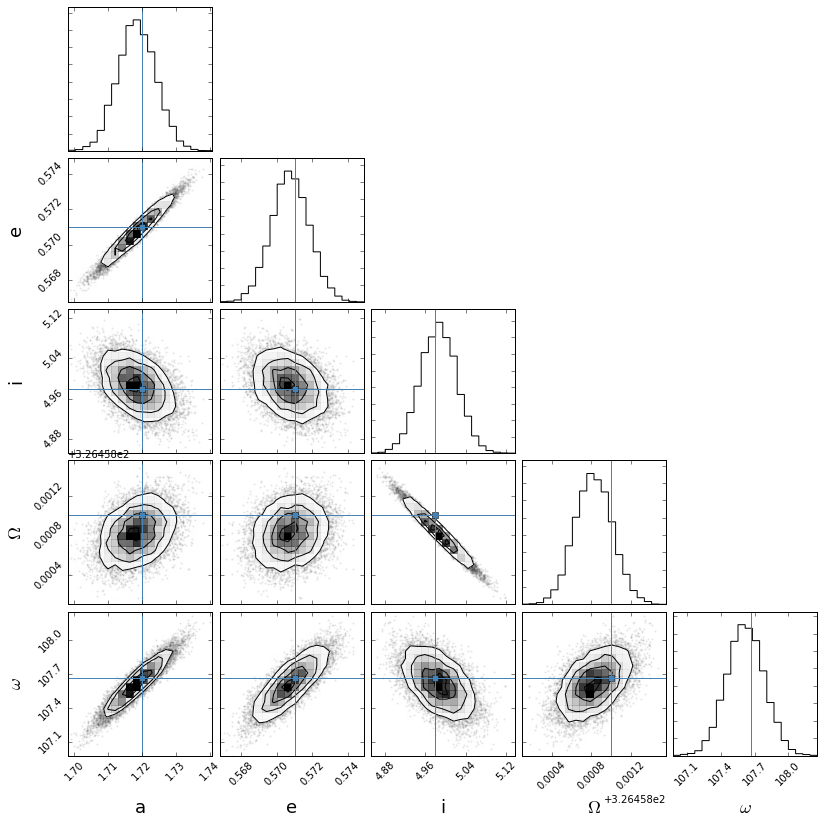

In [10]:
figure = corner.corner(samples, truths=[1.72,0.571,4.98,326.459,107.67],labels=["a","e","i","$\Omega$","$\omega$"], label_kwargs={"fontsize": 18})

Next, let us integrate the orbit further back in time. We reuse the simulation from earlier, but merge the Moon and the Earth and remove the variational particles.

In [45]:
simo = rebound.Simulation.from_file("ss2.bin")
sim = rebound.Simulation()
for i in range(simo.N_real):
    if i==3:
        continue
    elif i==4:
        mtot = simo.particles[3].m+simo.particles[4].m
        com = (simo.particles[3]*simo.particles[3].m + simo.particles[4]*simo.particles[4].m)/mtot
        sim.add(com)
    else:
        sim.add(simo.particles[i])
sim.move_to_com()

But first, let's plot the orbits 60 days pre-impact.

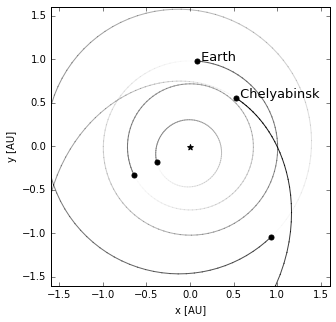

In [46]:
figure = rebound.OrbitPlot(sim,trails=True,lim=1.6,unitlabel="[AU]")
figure.axes[0].text(sim.particles[3].x, sim.particles[3].y, ' Earth', fontsize=13)
figure.axes[0].text(sim.particles[7].x, sim.particles[7].y, ' Chelyabinsk', fontsize=13);

We switch over to the symplectic integrator WHFast and record the orbit 10000 times over a one hundred thousand years integration. We can speed up the simulation by turning off the safemode (which is ok since we're not accessing particles during `integrate()` calls).

In [ ]:
#sim.integrator = "whfast"
#sim.integrator_whfast_safemode = 0

# Set timestep to small fraction of Mercury's orbital period
sim.dt = -sim.particles[1].P*0.01234
N=10000
samples2 = np.zeros((N,6))
times2 = np.linspace(0.,-1e3*2.*np.pi,N)
for i,t in enumerate(times):
    sim.integrate(t)
    o = sim.particles[7].calculate_orbit(primary = sim.particles[0])
    samples2[i] = [t] + sim.particles[7].xyz + [o.a,o.e]

We can now plot the semi-major axis and eccentricity as a function of time. There doesn't seem to be any close encounter in that timespan but the semi-major axis is clearly undergoing a axis walk. The eccentricity seems to change somehwhat more periodically. Note that we have calculated the orbit in the heliocentric coordinate system.

In [ ]:
f, axarr = plt.subplots(2, sharex=True, figsize=(8,5))
axarr[0].set_ylabel("a [AU]")
axarr[0].plot(samples[:,0]/np.pi/2.,samples[:,4])
axarr[0].plot(samples2[:,0]/np.pi/2.,samples2[:,4])
axarr[1].set_xlabel("time [yrs]")
axarr[1].set_ylabel("e")
axarr[1].plot(samples[:,0]/np.pi/2.,samples[:,5]);
axarr[1].plot(samples2[:,0]/np.pi/2.,samples2[:,5]);

We can also overplot the breadcrumbs of Chelyabinsk's orbit over the instantaneous orbits.

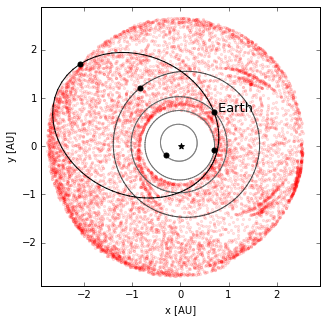

In [44]:
figure = rebound.OrbitPlot(sim,lim=2.9,unitlabel="[AU]")
figure.axes[0].text(sim.particles[3].x, sim.particles[3].y, ' Earth', fontsize=13)
figure.axes[0].scatter(samples[:,1],samples[:,2],alpha=0.1,marker=".",color="red")